In [143]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.ticker import MultipleLocator
import numpy as np
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
import math
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [32]:
df = pd.read_csv('train.csv', index_col='id')
df

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
id,,,,,,,,,,,,
0,100.0,0.841611,10.000000,4.800000,20.612526,11.088100,2.766000,1.732000,0.860000,0.496070,0.91457,6.0
1,100.0,7.558488,10.000000,4.800000,20.298893,12.040830,2.755000,1.631000,0.910000,0.492719,0.71760,6.5
2,76.0,8.885992,15.600000,5.600000,33.739258,12.086300,2.828000,1.788000,0.864000,0.481478,1.50633,2.5
3,100.0,8.795296,10.000000,4.800000,20.213349,10.948500,2.648000,1.626000,0.936000,0.489272,0.78937,6.0
4,116.0,9.577996,11.600000,4.800000,24.988133,11.824480,2.766000,1.682000,0.896000,0.492736,1.86481,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8


### Preprocess-Reduccion de dimensionalidad (PCA)

In [3]:
def reduc_pca(df):
    df_copy = df.copy()
    
    # Selecciona las características afectadas por multicolinealidad
    features_to_pca = df_copy[['allelectrons_Average', 'density_Average', 'R_vdw_element_Average', 'atomicweight_Average','zaratio_Average','R_cov_element_Average']]
    
    # Estandariza las características antes de aplicar PCA
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_to_pca)
    
    # Aplica PCA
    pca = PCA(n_components=0.95) 
    components = pca.fit_transform(features_scaled)
    print(f"Número de componentes seleccionados: {pca.n_components_}")
    
    # Crea nombres para los nuevos componentes
    new_component_names = [f'PCA_Component_{i+1}' for i in range(components.shape[1])]
    
    # Añade los nuevos componentes al DataFrame
    df_copy[new_component_names] = components
    
    # Elimina las características originales afectadas por multicolinealidad
    df_copy.drop(['allelectrons_Average', 'density_Average', 'R_vdw_element_Average', 'atomicweight_Average', 'zaratio_Average','R_cov_element_Average'], axis=1, inplace=True)
    
    # movemos Hardness al final del df
    Hardness = df_copy.pop('Hardness')
    df_copy['Hardness'] = Hardness
    
    return df_copy
    

In [33]:
df = reduc_pca(df)

Número de componentes seleccionados: 4


In [5]:
df.head()

,allelectrons_Total,density_Total,val_e_Average,ionenergy_Average,el_neg_chi_Average,PCA_Component_1,PCA_Component_2,PCA_Component_3,PCA_Component_4,Hardness
id,,,,,,,,,,
0,100.0,0.841611,4.8,11.08810,2.766,-1.111271,-0.149722,-0.401556,-0.026638,6.0
1,100.0,7.558488,4.8,12.04083,2.755,-1.224308,0.074271,-0.379823,0.083014,6.5
2,76.0,8.885992,5.6,12.08630,2.828,-0.321924,0.029238,-0.251617,0.128897,2.5
3,100.0,8.795296,4.8,10.94850,2.648,-1.146938,0.094446,-0.448528,0.047033,6.0
4,116.0,9.577996,4.8,11.82448,2.766,-0.746181,0.087805,-0.131870,-0.272518,6.0


### Eliminar valores atipicos (solo en dataset de entrenamiento)

In [6]:
# Eliminar atipicos
def outliers_iqr(df, column_names, lower_limit=0.01, upper_limit=0.99):
    copy_df = df.copy()
    
    for column_name in column_names:
        # Calcula percentiles para limitar los valores atípicos
        lower_percentile = copy_df[column_name].quantile(lower_limit)
        upper_percentile = copy_df[column_name].quantile(upper_limit)

        # Identifica y elimina las filas que contienen valores atípicos
        copy_df = copy_df[~((copy_df[column_name] < lower_percentile) | (copy_df[column_name] > upper_percentile))]

    return copy_df
    

In [34]:
df = outliers_iqr(df, ['allelectrons_Total','density_Total','ionenergy_Average','el_neg_chi_Average'], 
                            lower_limit=0.01, upper_limit=0.99)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   allelectrons_Total  9695 non-null   float64
 1   density_Total       9695 non-null   float64
 2   val_e_Average       9695 non-null   float64
 3   ionenergy_Average   9695 non-null   float64
 4   el_neg_chi_Average  9695 non-null   float64
 5   PCA_Component_1     9695 non-null   float64
 6   PCA_Component_2     9695 non-null   float64
 7   PCA_Component_3     9695 non-null   float64
 8   PCA_Component_4     9695 non-null   float64
 9   Hardness            9695 non-null   float64
dtypes: float64(10)
memory usage: 833.2 KB


In [43]:
# Guardar csv
df.to_csv('clustering_kmeans.csv', index=False)

In [116]:
# Separamos en X e y
X = df.iloc[:, :-1]
y = df.iloc[:, 9]

In [117]:
y

id
1        6.5
2        2.5
3        6.0
4        6.0
5        6.0
        ... 
10401    6.8
10402    4.0
10404    1.8
10405    6.0
10406    6.5
Name: Hardness, Length: 9695, dtype: float64

In [118]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9695 entries, 1 to 10406
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   allelectrons_Total  9695 non-null   float64
 1   density_Total       9695 non-null   float64
 2   val_e_Average       9695 non-null   float64
 3   ionenergy_Average   9695 non-null   float64
 4   el_neg_chi_Average  9695 non-null   float64
 5   PCA_Component_1     9695 non-null   float64
 6   PCA_Component_2     9695 non-null   float64
 7   PCA_Component_3     9695 non-null   float64
 8   PCA_Component_4     9695 non-null   float64
dtypes: float64(9)
memory usage: 1015.5 KB


### Algoritmo de agrupacion -  nuevas caracteristicas y patrones

In [12]:
# clase personalizada, prediccion de clusters.
class ClusteringClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        # Preservar nombre de columnas
        column_names = X_copy.columns.tolist()
        # Escalado
        scaler = StandardScaler()
        X_copy = scaler.fit_transform(X_copy)
        
        # kmeans
        kmeans = KMeans(n_clusters=7, init='k-means++', max_iter=300, n_init=10, random_state=42)
        y_kmeans = kmeans.fit_predict(X_copy)
        
        # Desescalado de X
        X_copy = scaler.inverse_transform(X_copy)
        
        # transformar a series de pandas(dataframe)
        X_copy = pd.DataFrame(X_copy, columns= column_names)
        
        # Unir nueva columna a X
        X_copy['cluster'] = y_kmeans.tolist()
        
        return X_copy

In [13]:
clustering_class = ClusteringClass()

In [91]:
X = clustering_class.transform(X)

In [84]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9695 entries, 0 to 9694
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   allelectrons_Total  9695 non-null   float64
 1   density_Total       9695 non-null   float64
 2   val_e_Average       9695 non-null   float64
 3   ionenergy_Average   9695 non-null   float64
 4   el_neg_chi_Average  9695 non-null   float64
 5   PCA_Component_1     9695 non-null   float64
 6   PCA_Component_2     9695 non-null   float64
 7   PCA_Component_3     9695 non-null   float64
 8   PCA_Component_4     9695 non-null   float64
 9   cluster             9695 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 757.6 KB


### Transformaciones matematicas

In [88]:
# clase personalizada, transformaciones de variables.
class MathClass(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):       
        return self  

    def transform(self, X):
        X_copy = X.copy()
        
        #Proporcion electrones por densidad
        X_copy['electronic_density'] = X_copy['allelectrons_Total']/X_copy['density_Total']
        #Valor medio electrones y energia de ionizacion
        X_copy['v_mean_elecIo'] = X_copy['val_e_Average']/X_copy['ionenergy_Average']
        return X_copy

In [89]:
math_class = MathClass()

In [92]:
X = math_class.transform(X)

In [93]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9695 entries, 0 to 9694
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   allelectrons_Total  9695 non-null   float64
 1   density_Total       9695 non-null   float64
 2   val_e_Average       9695 non-null   float64
 3   ionenergy_Average   9695 non-null   float64
 4   el_neg_chi_Average  9695 non-null   float64
 5   PCA_Component_1     9695 non-null   float64
 6   PCA_Component_2     9695 non-null   float64
 7   PCA_Component_3     9695 non-null   float64
 8   PCA_Component_4     9695 non-null   float64
 9   cluster             9695 non-null   int64  
 10  electronic_density  9695 non-null   float64
 11  v_mean_elecIo       9695 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 909.0 KB


In [98]:
# Importancia segun p-values de las caracteristicas nuevas
f_values, p_values = f_classif(X, y)
anova_results_df = pd.DataFrame({'Feature': X.columns, 'F-value': f_values, 'p-value': p_values})
anova_results_df = anova_results_df.sort_values(by='p-value', ascending=True)
print(anova_results_df)

               Feature    F-value        p-value
5      PCA_Component_1  43.979989   0.000000e+00
4   el_neg_chi_Average  32.902327  1.417517e-275
7      PCA_Component_3  29.591847  1.255243e-246
3    ionenergy_Average  17.936900  1.922169e-142
9              cluster  15.756929  1.141439e-122
1        density_Total   9.748841   2.815661e-68
2        val_e_Average   9.670318   1.424393e-67
11       v_mean_elecIo   9.282423   4.227465e-64
0   allelectrons_Total   5.824490   8.019356e-34
6      PCA_Component_2   4.203894   1.736403e-20
10  electronic_density   3.542289   2.242631e-15
8      PCA_Component_4   2.610539   9.357709e-09


### Prediccion con Random Forest, evaluacion y rectificado

In [101]:
# prediccion prueba con random forest
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [106]:
regressor = RandomForestRegressor(random_state=42, oob_score=True)
model = regressor.fit(X_train, y_train)

In [112]:
oob_score = model.oob_score_
print("R^2 Score:", oob_score)

R^2 Score: 0.4347923445116044


In [107]:
y_pred = model.predict(X_test)

In [111]:
#MSE y RMSE
mse = mean_squared_error(y_test, y_pred)
print(mse)
rmse=math.sqrt(mse)
print(rmse)
medae = median_absolute_error(y_test, y_pred)
print('MedAE:', medae)

1.754691255884476
1.3246475968666067
MedAE: 0.740999999999997


Hemos obtenido una mejora con respecto a la baseline inicial.
Probaremos con otro modelo mas complejo.

*la evaluacion de los modelos en la competicion se realiza con la metrica medae (mediana)*

---------------------------------------

Baseline -> MedAE: 0.97

RandomForest -> MedAE: 0.74

### Automatizacion de preprocesado con pipeline

In [134]:
inicial_pipeline = make_pipeline(clustering_class, math_class)

# escalado de numericas (en este caso todo X)
num_pipeline = make_pipeline(StandardScaler())

# todas las variables (se podria hacer incluyendo las de tipo numerica sin necesidad de pasar todas una por una)
preprocessing = ColumnTransformer([
    ('num', num_pipeline, ['PCA_Component_1', 'el_neg_chi_Average', 'PCA_Component_3', 'ionenergy_Average', 'cluster', 'density_Total','val_e_Average','v_mean_elecIo',
                          'allelectrons_Total','PCA_Component_2','electronic_density','PCA_Component_4']),
])
# union de pipeline
pipe = make_pipeline(inicial_pipeline, preprocessing)

X_processed = pipe.fit_transform(X)
X_processed

array([[-0.65783055,  0.50744241, -0.503408  , ...,  0.28712437,
         0.32953688,  0.18720527],
       [-0.16273629,  0.80965726, -0.32992093, ...,  0.1955307 ,
        -0.23909051,  0.28077472],
       [-0.61538116,  0.06446996, -0.59637804, ...,  0.32816024,
         0.10336283,  0.11382812],
       ...,
       [ 0.43463569, -1.39692515,  0.19604923, ...,  1.49830014,
        -0.5082277 ,  1.23098601],
       [-0.28568881,  0.45914323, -0.94582439, ..., -0.37249962,
         1.69550666,  0.40672902],
       [-0.38848849,  0.66121122, -0.83657454, ..., -0.55185269,
         0.14121132, -0.01034159]])

In [135]:
# Preservar nombre de columnas
ultimo_paso = pipe.steps[-1][1]
# verificar si el ultmo paso es un ColumnTransformer
if isinstance(ultimo_paso, ColumnTransformer):
    # Obtén los nombres de las columnas después de la transformación
    nombres_columnas_procesadas = ultimo_paso.get_feature_names_out()
else:
    # Si no es un ColumnTransformer, intenta obtener los nombres de las columnas directamente
    try:
        nombres_columnas_procesadas = ultimo_paso.get_feature_names_out()
    except AttributeError:
        # Si no es posible obtener los nombres de las columnas, muestra un mensaje de advertencia
        print("No se pudieron obtener los nombres de las columnas después de aplicar el pipeline.")
        
# Crea un DataFrame con los datos procesados y los nombres de las columnas
X_processed_df = pd.DataFrame(X_processed, columns=nombres_columnas_procesadas)


In [137]:
X_processed_df.head()

,num__PCA_Component_1,num__el_neg_chi_Average,num__PCA_Component_3,num__ionenergy_Average,num__cluster,num__density_Total,num__val_e_Average,num__v_mean_elecIo,num__allelectrons_Total,num__PCA_Component_2,num__electronic_density,num__PCA_Component_4
0,-0.657831,0.507442,-0.503408,1.051762,-0.844886,-0.636940,0.386058,-0.333520,-0.197588,0.287124,0.329537,0.187205
1,-0.162736,0.809657,-0.329921,1.099682,-0.844886,-0.486807,1.844917,0.775311,-0.502202,0.195531,-0.239091,0.280775
2,-0.615381,0.064470,-0.596378,-0.099423,-0.844886,-0.497064,0.386058,0.348201,-0.197588,0.328160,0.103363,0.113828
3,-0.395506,0.552982,-0.167880,0.823755,-0.844886,-0.408545,0.386058,-0.208499,0.005488,0.314653,0.193492,-0.537839
4,0.371053,0.935235,0.319162,0.954141,1.747529,1.282366,0.142915,-0.471822,0.195872,1.150897,-0.629602,0.107537


### Prediccion con Redes Neuronales

In [140]:
# prediccion prueba con redes neuronales
# Divide tus datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_processed_df, y, test_size=0.2, random_state=42)

In [242]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_dim=12),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss='mse', metrics=['RootMeanSquaredError'])

model_summary = model.summary()
print(model_summary)

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_24 (Flatten)        (None, 12)                0         
                                                                 
 dense_89 (Dense)            (None, 300)               3900      
                                                                 
 dense_90 (Dense)            (None, 1)                 301       
                                                                 
Total params: 4201 (16.41 KB)
Trainable params: 4201 (16.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [243]:
# Ajustar y entrenar el modelo de red neuronal
history=model.fit(X_train, y_train, batch_size=35, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
222/222 [==============================] - 1s 3ms/step - loss: 12.3766 - root_mean_squared_error: 3.5180 - val_loss: 4.9771 - val_root_mean_squared_error: 2.2309
Epoch 2/100
222/222 [==============================] - 0s 2ms/step - loss: 3.4572 - root_mean_squared_error: 1.8594 - val_loss: 3.1367 - val_root_mean_squared_error: 1.7711
Epoch 3/100
222/222 [==============================] - 0s 2ms/step - loss: 2.7021 - root_mean_squared_error: 1.6438 - val_loss: 2.7191 - val_root_mean_squared_error: 1.6490
Epoch 4/100
222/222 [==============================] - 0s 2ms/step - loss: 2.4004 - root_mean_squared_error: 1.5493 - val_loss: 2.4711 - val_root_mean_squared_error: 1.5720
Epoch 5/100
222/222 [==============================] - 0s 2ms/step - loss: 2.1992 - root_mean_squared_error: 1.4830 - val_loss: 2.3123 - val_root_mean_squared_error: 1.5206
Epoch 6/100
222/222 [==============================] - 0s 2ms/step - loss: 2.0730 - root_mean_squared_error: 1.4398 - val_loss: 2.1798

222/222 [==============================] - 0s 2ms/step - loss: 1.5842 - root_mean_squared_error: 1.2587 - val_loss: 1.8035 - val_root_mean_squared_error: 1.3429
Epoch 49/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5799 - root_mean_squared_error: 1.2569 - val_loss: 1.7971 - val_root_mean_squared_error: 1.3406
Epoch 50/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5807 - root_mean_squared_error: 1.2573 - val_loss: 1.7951 - val_root_mean_squared_error: 1.3398
Epoch 51/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5790 - root_mean_squared_error: 1.2566 - val_loss: 1.7912 - val_root_mean_squared_error: 1.3384
Epoch 52/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5760 - root_mean_squared_error: 1.2554 - val_loss: 1.8038 - val_root_mean_squared_error: 1.3431
Epoch 53/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5703 - root_mean_squared_error: 1.2531 - val_loss: 1.7945 - val_r

222/222 [==============================] - 0s 2ms/step - loss: 1.5221 - root_mean_squared_error: 1.2337 - val_loss: 1.7962 - val_root_mean_squared_error: 1.3402
Epoch 96/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5184 - root_mean_squared_error: 1.2322 - val_loss: 1.7987 - val_root_mean_squared_error: 1.3412
Epoch 97/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5189 - root_mean_squared_error: 1.2324 - val_loss: 1.8074 - val_root_mean_squared_error: 1.3444
Epoch 98/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5150 - root_mean_squared_error: 1.2309 - val_loss: 1.7943 - val_root_mean_squared_error: 1.3395
Epoch 99/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5128 - root_mean_squared_error: 1.2299 - val_loss: 1.7961 - val_root_mean_squared_error: 1.3402
Epoch 100/100
222/222 [==============================] - 0s 2ms/step - loss: 1.5164 - root_mean_squared_error: 1.2314 - val_loss: 1.7935 - val_

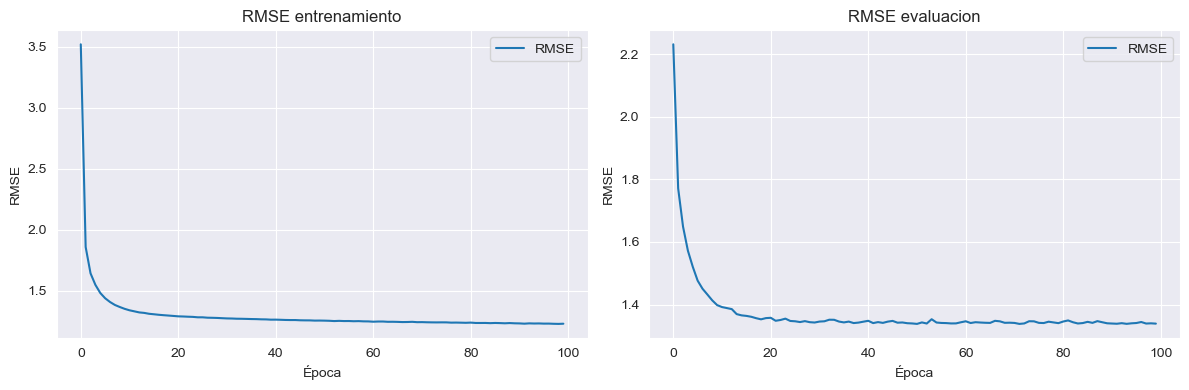

In [244]:
# Obtener las métricas de entrenamiento
loss = history.history['root_mean_squared_error']
mse = history.history['val_root_mean_squared_error']

# Graficar la pérdida y la métrica MSE
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(loss, label='RMSE')
plt.title('RMSE entrenamiento')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Gráfico de la métrica MSE
plt.subplot(1, 2, 2)
plt.plot(mse, label='RMSE')
plt.title('RMSE evaluacion')
plt.xlabel('Época')
plt.ylabel('RMSE')
plt.legend()

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [245]:
mse_test, rmse_test = model.evaluate(X_test, y_test)

61/61 [==============================] - 0s 1ms/step - loss: 1.7935 - root_mean_squared_error: 1.3392


In [246]:
print('mse=',mse_test)
print('rmse=',rmse_test)

mse= 1.793524146080017
rmse= 1.339225172996521
